In [1]:
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [4]:
from botorch.models.gp_regression import SingleTaskGP
from botorch.models.transforms.outcome import Standardize

import torch
tkwargs = {
    "dtype": torch.double,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({"text.usetex": True,
                     "axes.spines.right" : False,
                     "axes.spines.top" : False,
                     "font.size": 20,
                     "savefig.dpi": 500,
                     "savefig.bbox": 'tight',
                     'text.latex.preamble': r'\usepackage{amsfonts}\usepackage[version=4]{mhchem}'
                    }
                   )
from matplotlib import cm
from matplotlib.colors import Normalize
import torch
from head import InputTransform, Grid

INFO: Using numpy backend


In [5]:
TARGET_SHAPE = 'Easy'

if TARGET_SHAPE=='Easy':
    target = [6.2,3.6]
    target_spectra = np.asarray(pd.read_excel('./expt/Target_Easy.xlsx'))
elif TARGET_SHAPE=='Hard':
    target = [0,0]
    target_spectra = np.asarray(pd.read_excel('./expt/Target_Hard.xlsx'))   
AG = [0,7.38] 
AA = [0,7.27]
bounds = [AG, AA]
bounds_params = torch.tensor(bounds).T.to(**tkwargs)
inp = InputTransform(bounds_params)

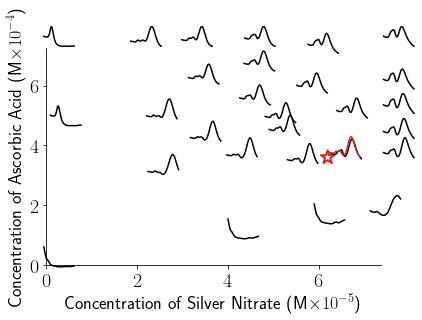

In [6]:
def inset_spectra(loc,data, ax, **kwargs):
    loc_ax = ax.transLimits.transform(loc)
    ins_ax = ax.inset_axes([loc_ax[0],loc_ax[1],0.1,0.1])
    ins_ax.plot(target_spectra[:,0], data, **kwargs)
    ins_ax.axis('off')

    return
    
def embed_spectra(ax, directory):
    for i in range(7):
        idirec = directory + '/%d'%i 
        iter_spectra = pd.read_excel(idirec+'.xlsx')
        iter_comps = np.load(directory + '/%d'%(i) +'/new_x.npy')
        AG_x = iter_comps[:,0]*0.00064/350*10**5
        AA_x = iter_comps[:,1]*0.00630/350*10**4
        iter_comps = np.hstack((AG_x.reshape(-1,1)-0.1, AA_x.reshape(-1,1)-0.1))
        for ind,comp in enumerate(iter_comps):
            inset_spectra(comp, iter_spectra.iloc[:,ind+1], ax, color='k')
    ax.scatter(target[0], target[1], 
               marker='*', s=200,color='tab:red', lw=2.0,fc='none', label='Target')
    inset_spectra(target, target_spectra[:,1], ax, color='tab:red')
      
    return 

fig, ax = plt.subplots()
ax.set_xlim(bounds[0])
ax.set_ylim(bounds[1])
directory = './expt/data_AP_%s'%TARGET_SHAPE
embed_spectra(ax, directory)
ax.set_xlabel(r'Concentration of Silver Nitrate (M$\times 10^{-5}$)', fontsize = 18)
ax.set_ylabel(r'Concentration of Ascorbic Acid (M$\times 10^{-4}$)', fontsize = 18)
plt.show()

In [7]:
class Visualize:
    def __init__(self, directory):
        self.dir = directory
        self.min_postmean = {}
        
    def get_model(self, iteration):
        idirec = self.dir + '/%d'%iteration 
        self.train_x = torch.from_numpy(np.load(idirec+'/train_x.npy')).to(**tkwargs)
        self.train_obj = torch.from_numpy(np.load(idirec+'/train_obj.npy')).to(**tkwargs)
        model = SingleTaskGP(self.train_x, self.train_obj, 
                    outcome_transform=Standardize(m=self.train_obj.shape[-1]))
        state_dict = torch.load(idirec+'/model.pth')
        model.load_state_dict(state_dict)
        self.model = model
        try:
            self.best_estimate = pd.read_excel(self.dir+'/Best_Estimate_%d.xlsx'%(iteration))
        except:
            self.best_estimate = None
    
        with torch.no_grad():
            num_grid_spacing = 20
            mu_grid = np.linspace(*bounds[0], num=num_grid_spacing)
            sig_grid = np.linspace(*bounds[1], num=num_grid_spacing)
            self.test_x = Grid(mu_grid, sig_grid).points
            self.test_x_t = inp.transform(torch.tensor(self.test_x).to(**tkwargs))
            posterior = self.model.posterior(self.test_x_t)
            self.posterior_mean = posterior.mean.cpu().numpy()
            lower, upper = posterior.mvn.confidence_region()
            self.confidence = np.abs((lower-upper).numpy())

            self.XX, self.YY = np.meshgrid(mu_grid, sig_grid)
            self.Z = self.posterior_mean.reshape(num_grid_spacing,num_grid_spacing)
        
        self.min_postmean[iteration] = self.posterior_mean.min()
        
        return
    
    def plot_model_3d(self, iteration):
        self.get_model(iteration)
        sc = ax.plot_surface(self.XX, self.YY, self.Z, 
                             rstride=1, cstride=1, 
                             linewidth=1, antialiased=True, shade=False) 
            
        return 
    
    def plot_model_contour(self, iteration, fig, ax, vmin, 
                           annotate=True):
        self.get_model(iteration)
        ax.set_xlim(bounds[0])
        ax.set_ylim(bounds[1])

        im = ax.contourf(self.XX, self.YY, self.Z, cmap=cm.Blues, 
                         vmin=vmin, vmax=0)

        ax.scatter(target[0], target[1], 
                   marker='*', s=200,color='tab:red', lw=2.0,fc='none', label='Target')
        inset_spectra(target, target_spectra[:,1], ax, color='tab:red')

        opt_x = self.test_x[np.argmax(self.posterior_mean),:]
        ax.scatter(opt_x[0], opt_x[1],
                  marker='*', s=200,color='tab:orange', lw=2.0,fc='none', label='Estimate')
        
        if self.best_estimate is not None:
            inset_spectra(opt_x, self.best_estimate.iloc[:,1], ax, ls='--', color='k')


        train_x_unscaled = inp.inverse(self.train_x)
        ax.scatter(train_x_unscaled[:,0], train_x_unscaled[:,1], 
                   marker='o', fc='none', edgecolors=(0,0,0), 
                   lw=2.0, alpha=0.5, label='Collected')
        if annotate:
            handles, labels = ax.get_legend_handles_labels()
            fig.legend(handles, labels, 
                       ncol=3 ,
                       loc='upper center', 
                       bbox_to_anchor=[0.5,1.1])

            cax = plt.axes([0.995, 0.2, 0.03, 0.6])        
            cbar = fig.colorbar(im, cax=cax)
            cbar.ax.set_ylabel('Distance', rotation=270)
            cbar.ax.get_yaxis().labelpad = 15
        
        return im
    
    def embed_spectra(self, iteration, ax):
        for i in range(iteration):
            idirec = self.dir + '/%d'%i 
            iter_spectra = pd.read_excel(idirec+'.xlsx')
            iter_comps = np.load(self.dir + '/%d'%(i) +'/new_x.npy')
            AG_x = iter_comps[:,0]*0.00064/350*10**5
            AA_x = iter_comps[:,1]*0.00630/350*10**4
            iter_comps = np.hstack((AG_x.reshape(-1,1)-0.1, AA_x.reshape(-1,1)-0.1))
            for ind,comp in enumerate(iter_comps):
                inset_spectra(comp, iter_spectra.iloc[:,ind+1], 
                              ax, color='k', alpha=0.75, lw=0.5)
      
        return 
    
    def plot_best_spectra_trace(self):
        fig, ax = plt.subplots()
        ax.plot(target_spectra[:,0],target_spectra[:,1], ls='--', lw=2.0)
        cmap = cm.get_cmap('coolwarm')
        norm = Normalize(vmin=1, vmax = 6)
        for i in range(1,7):
            self.best_estimate = pd.read_excel(self.dir+'/Best_Estimate_%d.xlsx'%i)
            ax.plot(self.best_estimate.iloc[:,0],self.best_estimate.iloc[:,1],
                   color=cmap(norm(i)), lw=2.0)
        
        cax = plt.axes([0.95, 0.2, 0.02, 0.6])        
        cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax)
        cbar.ax.set_ylabel('Batch number', rotation=270)
        cbar.ax.get_yaxis().labelpad = 15
        plt.show()

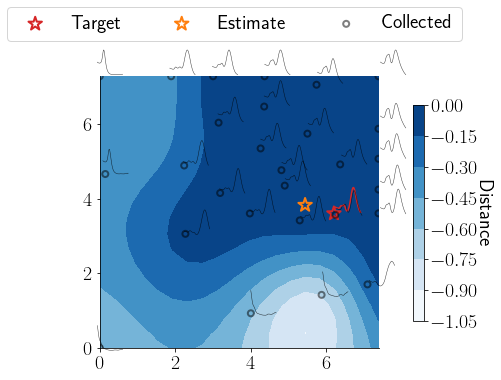

In [8]:
viz = Visualize('./expt/data_AP_%s'%TARGET_SHAPE)
fig, ax = plt.subplots(figsize=(5,5))
ITERATION = 7
viz.plot_model_contour(ITERATION, fig, ax, -1, annotate=True)
viz.embed_spectra(ITERATION, ax)

In [9]:
def setup_axs():
    top = [
        [0, 1, 2, 3]
    ]

    bottom = [
        [4, 5, 6],
    ]

    outer_nested_mosaic = [
        [top],
        [bottom],
    ]
    fig = plt.figure(constrained_layout=True, figsize=(4*4,4*2))
    axs = fig.subplot_mosaic(
        outer_nested_mosaic, empty_sentinel=None
    )
    
    return fig, axs

In [10]:
from botorch.acquisition.monte_carlo import  qExpectedImprovement

def plot_acquisition(direc, save=False):
    data_dir = '%s_%s'%(direc,TARGET_SHAPE)
    viz = Visualize(data_dir)
    fig, axs = setup_axs()
    fig.subplots_adjust(wspace=0.3, hspace=0.6)
    for i in range(1,8):
        viz.get_model(i)
        ax = axs[i-1]
        with torch.no_grad():
            acquisition = qExpectedImprovement(viz.model, best_f = 0.0)
            acq_values = acquisition(viz.test_x_t.reshape(400,1,2)).cpu().numpy()
            acq_values = 100*(acq_values/max(acq_values))
        im = ax.contourf(viz.XX, viz.YY, 
                         acq_values.reshape(20,20), 
                         cmap=cm.coolwarm,
                        vmin = 0, vmax = 100)
        #fig.colorbar(im, ax=ax)
        iter_comps = np.load(viz.dir + '/%d'%(i) +'/new_x.npy')
        AG_x = iter_comps[:,0]*0.00064/350*10**5
        AA_x = iter_comps[:,1]*0.00630/350*10**4
        iter_comps = np.hstack((AG_x.reshape(-1,1)-0.1, AA_x.reshape(-1,1)-0.1))
        ax.scatter(iter_comps[:,0], iter_comps[:,1], marker='x', color='k')

        ax.set_title('Iteration : %d'%(i))
        
    cmap = cm.get_cmap('coolwarm')
    norm = Normalize(vmin=0, vmax = 100)
    mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
    cax = plt.axes([0.95, 0.2, 0.01, 0.6])        
    cbar = fig.colorbar(mappable, cax=cax)
    cbar.ax.set_ylabel('Expected Improvement \%', rotation=270)
    cbar.ax.get_yaxis().labelpad = 15
    
    plt.show()

In [11]:
def plot_datadir(direc, vmin, label='Distance',save=False):
    data_dir = '%s_%s'%(direc,TARGET_SHAPE)
    viz = Visualize(data_dir)
    fig, axs = setup_axs()
    fig.subplots_adjust(wspace=0.3, hspace=0.6)
    for i, (_,ax) in enumerate(axs.items()):
        im = viz.plot_model_contour(i+1, fig, ax, vmin=vmin, 
                                    annotate=False)
        viz.embed_spectra(i+1, ax)
        ax.set_title('Iteration : %d'%(i+1))

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, 
               ncol=3 ,
               loc='upper center', 
               bbox_to_anchor=[0.5,1.1])
    
    cmap = cm.get_cmap('Blues')
    norm = Normalize(vmin=vmin, vmax = 0)
    mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
    cax = plt.axes([0.95, 0.2, 0.01, 0.6])        
    cbar = fig.colorbar(mappable, cax=cax)
    #cbar.ax.set_ylabel(label, rotation=270)
    cbar.ax.set_title(label, pad=25)
    cbar.ax.get_yaxis().labelpad = 15
    
    return viz

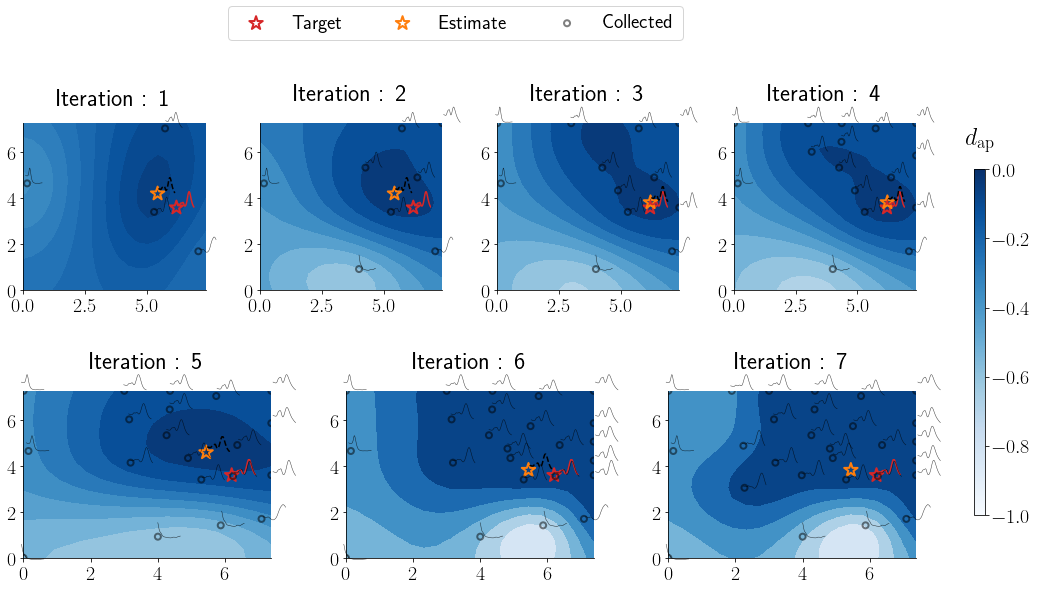

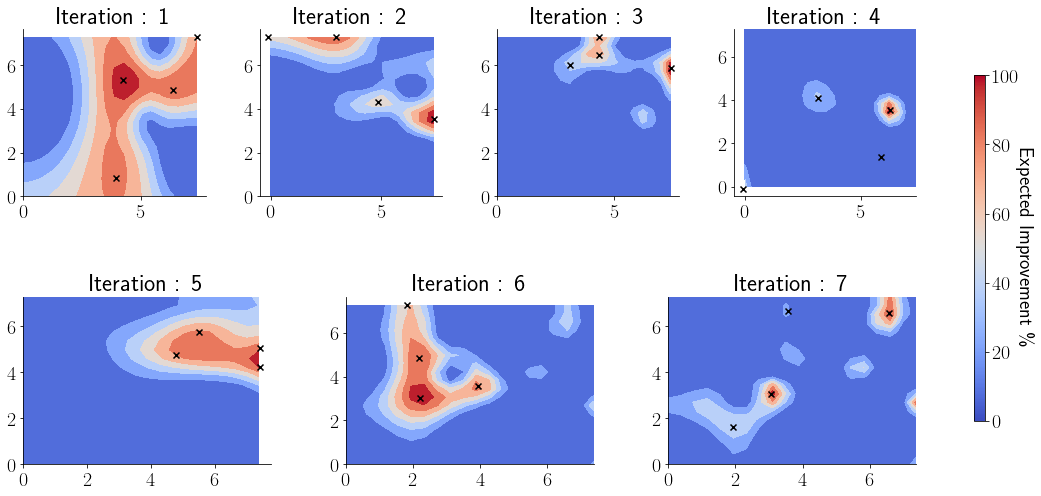

In [12]:
viz = plot_datadir('./expt/data_AP', vmin=-1, save=True, label=r'$d_{\mathrm{ap}}$')
plot_acquisition('./expt/data_AP', save=True)

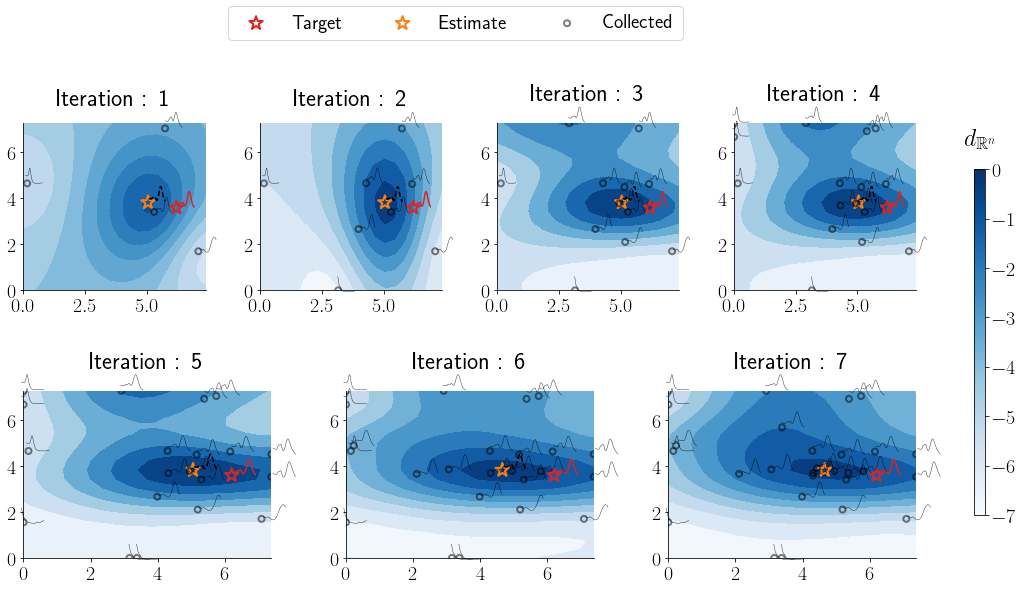

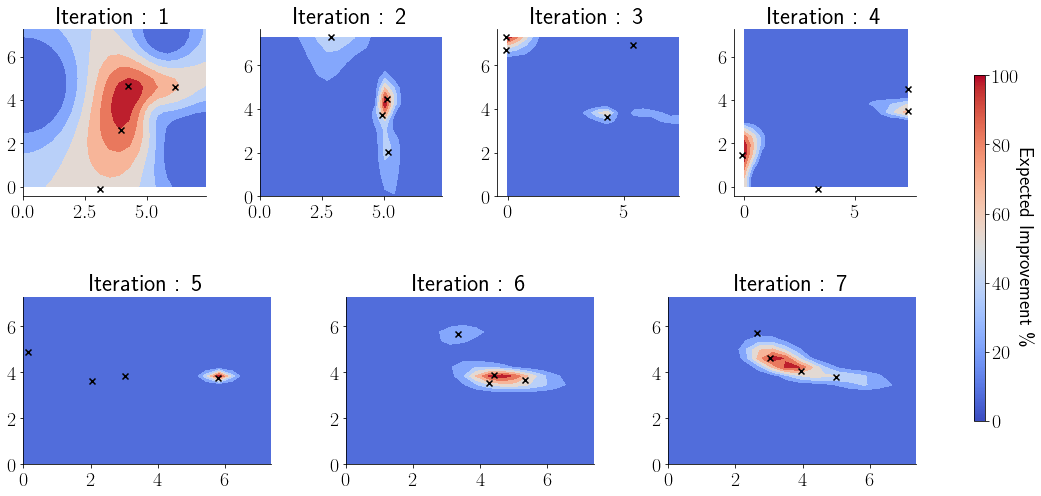

In [13]:
viz = plot_datadir('./expt/data_euclidean', vmin=-7, save=True, label=r'$d_{\mathbb{R}^n}$')
plot_acquisition('./expt/data_euclidean', save=True)

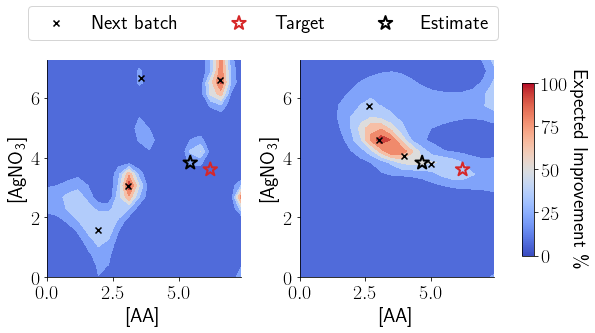

In [14]:
def plot_final_acq(direc, ax):
    data_dir = '%s_%s'%(direc,TARGET_SHAPE)
    viz = Visualize(data_dir)

    ITERATION = 7
    viz.get_model(ITERATION)
    with torch.no_grad():
        acquisition = qExpectedImprovement(viz.model, best_f = 0.0)
        acq_values = acquisition(viz.test_x_t.reshape(400,1,2)).cpu().numpy()
        acq_values = 100*(acq_values/max(acq_values))
    im = ax.contourf(viz.XX, viz.YY, 
                     acq_values.reshape(20,20), 
                     cmap=cm.coolwarm)
    iter_comps = np.load(viz.dir + '/%d'%(ITERATION) +'/new_x.npy')
    AG_x = iter_comps[:,0]*0.00064/350*10**5
    AA_x = iter_comps[:,1]*0.00630/350*10**4
    iter_comps = np.hstack((AG_x.reshape(-1,1)-0.1, AA_x.reshape(-1,1)-0.1))
    ax.scatter(iter_comps[:,0], iter_comps[:,1], 
               marker='x', color='k', label='Next batch')
    ax.scatter(target[0], target[1], 
               marker='*', s=200,color='tab:red', 
               lw=2.0,fc='none', label='Target')

    opt_x = viz.test_x[np.argmax(viz.posterior_mean),:]
    ax.scatter(opt_x[0], opt_x[1],
              marker='*', s=200,color='k', 
               lw=2.0,fc='none', label='Estimate')
    ax.set_xlabel(r'[AA]')
    ax.set_ylabel(r'[\ce{AgNO_{3}}]')
    
    return

fig, axs = plt.subplots(1,2, figsize=(4*2,4))
fig.subplots_adjust(wspace=0.3)
plot_final_acq('./expt/data_AP',axs[0])
plot_final_acq('./expt/data_euclidean',axs[1])
cmap = cm.get_cmap('coolwarm')
norm = Normalize(vmin=0, vmax = 100)
mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
cax = plt.axes([0.95, 0.2, 0.02, 0.6])        
cbar = fig.colorbar(mappable, cax=cax)
cbar.ax.set_ylabel('Expected Improvement \%', rotation=270)
cbar.ax.get_yaxis().labelpad = 20
handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels, ncol=3 ,loc='upper center', bbox_to_anchor=[0.5,1.1])

plt.show()

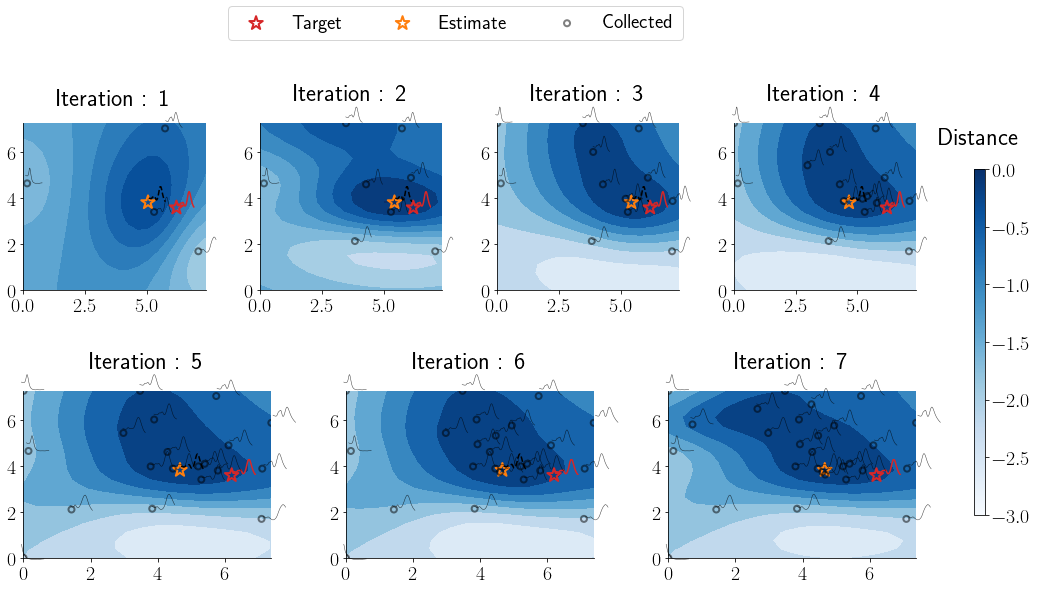

In [15]:
viz = plot_datadir('./expt/data_peakwv', vmin=-3)

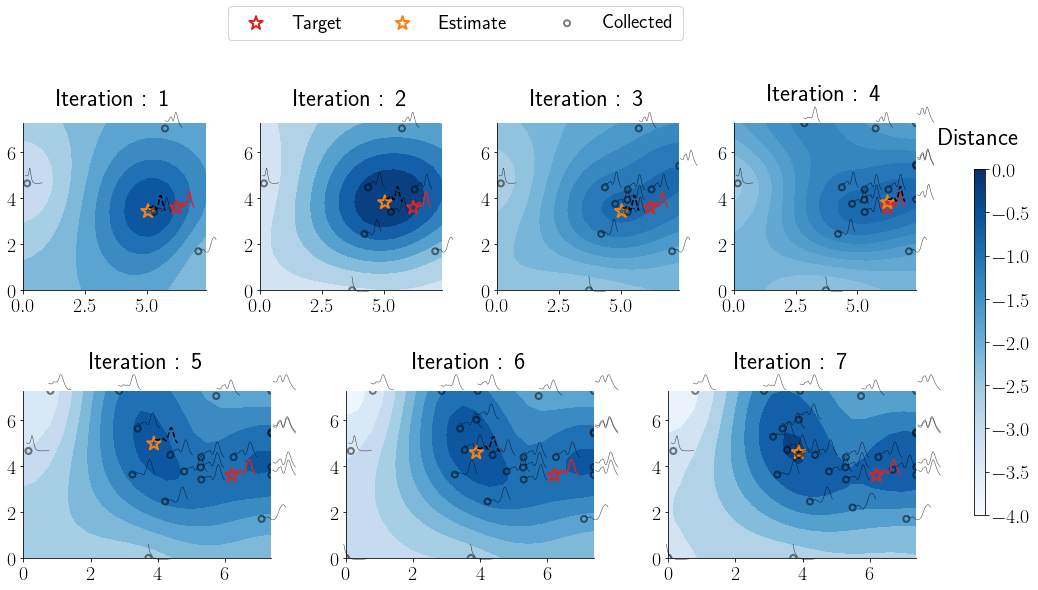

In [16]:
viz = plot_datadir('./expt/data_SRVF', vmin=-4)